# Content Based Filtering : Revue des données

Il s'agit ici d'un préambule à l'établissement du script d'entrainement et de prédiction de recommendation d'articles. Ce notebook comprends une revue des données fournies dans le cadre du projet, de l'utilisation des coefficients de similarité entre article de sklearn

In [1]:
# Import Package nécessaire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

import sklearn

import math

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from operator import itemgetter


In [2]:
print("Chargement des métadonnées des articles...")
meta_df= pd.read_csv("./news-portal-user-interactions-by-globocom/articles_metadata.csv")
meta_df.head()

Chargement des métadonnées des articles...


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


Depuis le site https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom?select=articles_metadata.csv, les variables représentent:
- article_id = The article id
- category_id = The category id of the article
- created_at_ts = Timestamp of the article published date
- publisher_id = Id of the publisher of the article
- words_count = # of words in the article

In [3]:
print("Dimensions du DataFrame...")
meta_df.shape

Dimensions du DataFrame...


(364047, 5)

In [4]:
print("Chargement du fichier d'exemple des clicks...")
exemple_click = pd.read_csv("./news-portal-user-interactions-by-globocom/clicks_sample.csv")
exemple_click.head()

Chargement du fichier d'exemple des clicks...


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


Depuis le site https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom?select=articles_metadata.csv, les variables représentent:
- user_id = The user id
- session_id = The session id
- session_start = Timestamp of the first interaction of the session
- session_size = Number of interactions of the session
- click_article_id = Article id interacted by the user
- click_timestamp = Timestamp of the interaction
- click_environment = Id of the Environment: 1 - Facebook Instant Article, 2 - Mobile App, 3 - AMP (Accelerated Mobile Pages), 4 - Web
- click_deviceGroup = Id of the Device Type: 1 - Tablet, 2 - TV, 3 - Empty, 4 - Mobile, 5 - Desktop
- click_os = Id of the Operational System: 1 - Other, 2 - iOS, 3 - Android, 4 - Windows Phone, 5 - Windows Mobile, 6 - Windows, 7 - 
- click_country = Id of the country
- click_region = n/a
- click_referrer_type = n/a

Il semble que article_id et click_article_id soient identiques.

Nous avons 385 fichiers de clics (1 par heure) inclus dans le dossier "./news-portal-user-interactions-by-globocom/clicks/" allant de clicks_hour_000 à clicks_hour_384

Il y a un également un fichier pickle qui contient les vecteurs d'embeddings du contenu des articles.

In [5]:
print("Chargement du fichier d'embedding des articles")
pickle = pd.read_pickle('./news-portal-user-interactions-by-globocom/articles_embeddings.pickle')
pickle

Chargement du fichier d'embedding des articles


array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [6]:
print("Dimensions de la matrice d'embeddings...")
pickle.shape

Dimensions de la matrice d'embeddings...


(364047, 250)

il y a donc bien 364047 articles pris en compte dans les fichiers

Il faudrait regrouper les fichiers de clic pour que ce soit plus facile à utiliser

In [7]:
print("Création d'un fichier globale des actions utilisateurs et chargement du fichier....")
if not os.path.exists('./news-portal-user-interactions-by-globocom/clicks_sum.csv'):
    file_dir = "./news-portal-user-interactions-by-globocom/clicks"
    file_path_list = sorted(
        [
            os.path.join(file_dir, file_name) 
            for file_name in os.listdir(file_dir)
            if file_name.endswith(".csv")
        ]
    )
    print(f"Nombre de fichiers .csv retenus: {len(file_path_list)}")
    
    file_df_list = []
    
    for file_path in file_path_list:
        df = pd.read_csv(file_path)
        file_df_list.append(df)
    
    clicks_sum = pd.concat(file_df_list, ignore_index=True)
    clicks_sum.to_csv('./news-portal-user-interactions-by-globocom/clicks_sum.csv')
else:
    clicks_sum= pd.read_csv('./news-portal-user-interactions-by-globocom/clicks_sum.csv')
    
clicks_sum.head()

Création d'un fichier globale des actions utilisateurs et chargement du fichier....


,Unnamed: 0,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [8]:
print('Dimensions du fichier globale des actions utilisateurs...')
clicks_sum.shape

Dimensions du fichier globale des actions utilisateurs...


(2988181, 13)

In [9]:
print(f"Quantité de variables par type dans notre jeu de données clicks_sum:\n\
{clicks_sum.dtypes.value_counts()}")

Quantité de variables par type dans notre jeu de données clicks_sum:
int64    13
dtype: int64


In [10]:
print(f"Quantité de valeurs manquantes par variable de clicks_sum:\n\
{clicks_sum.isna().sum()}")

Quantité de valeurs manquantes par variable de clicks_sum:
Unnamed: 0             0
user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64


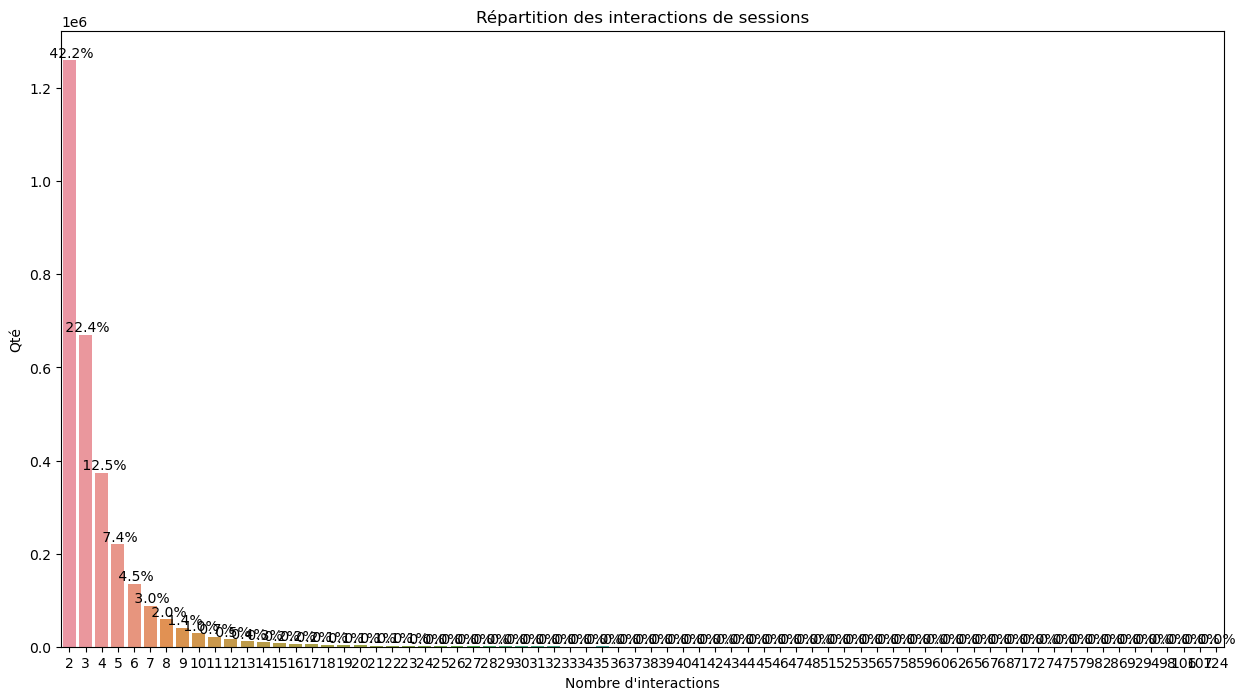

In [11]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='session_size', data=clicks_sum)
#Pour rajouter un texte au dessus/à coté des barres de notre diagramme
for c in ax.containers:
    # calcul du label en % en fonction de la hauteur/largeur
    # Rajoute un espace pour les valeurs nulles
    labels = [f' {h/clicks_sum.session_size.count()*100:0.1f}%' 
              if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')

plt.title('Répartition des interactions de sessions')
plt.xlabel("Nombre d'interactions")
plt.ylabel('Qté')
plt.show()

## Content Based filtering


Nous allons utiliser le principe du cosine similarities en nous basant sur le fichier d'embedding. Cependant, cette information seule ne nous permet de récupérer que les informations de similiraté entre les articles.


In [12]:

def find_top_n_indices(data, top=5):
    indexed = enumerate(data)
    sorted_data = sorted(indexed, 
                         key=itemgetter(1), 
                         reverse=True) 
    return [d[0] for d in sorted_data[:top]] 

In [13]:
def recommendFromArticle(article_id, top):
    score = []
    for i in range(0, len(pickle)):
        if(article_id != i):
            cos_sim = np.dot(pickle[article_id], pickle[i])/(np.linalg.norm(pickle[article_id])*np.linalg.norm(pickle[i]))
            score.append(cos_sim)
    
    _best_scores = find_top_n_indices(score, top)
            
    return _best_scores

In [14]:
%%time
print(f"articles similaire à l'article 157077: {recommendFromArticle(157077, 5)}")

articles similaire à l'article 157077: [156576, 159580, 158063, 159644, 161399]
CPU times: user 1.5 s, sys: 30.6 ms, total: 1.53 s
Wall time: 1.54 s


In [15]:
def recommendFromArticle(article_id, top):
    score = []
    for i in range(0, len(pickle)):
        if(article_id != i):
            cos_sim = cosine_similarity(pickle[article_id:article_id+1], pickle[i:i+1])
            score.append(cos_sim)
    
    _best_scores = find_top_n_indices(score, top)
            
    return _best_scores

In [16]:
%%time
print(f"articles similaire à l'article 157077: {recommendFromArticle(157077, 5)}")

articles similaire à l'article 157077: [156576, 159580, 158063, 159644, 161399]
CPU times: user 22.2 s, sys: 396 ms, total: 22.6 s
Wall time: 22.4 s


Il est possible de constater que l'utilisation du modulencosine_similatiry de sklearn prend plus de temps que le calcul pur.

Cependant, il nous manque ici le lien avec l'utilisateur. Pour pouvoir lier le contenu des articles avec l'utilisateur, il est utile d'avoir un profil de l'utilisateur pour connaitre ce qu'il préfère lire. Nous allons pour cela utiliser l'interaction de l'utilisateur avec les articles pour connaitre ses goûts.

In [17]:
print("Création et chargement d'un fichier regroupant les métadonnées et les interaction utilisateur...")
all_data = clicks_sum.merge(meta_df,
                            left_on='click_article_id',
                            right_on='article_id')
all_data.head()

Création et chargement d'un fichier regroupant les métadonnées et les interaction utilisateur...


,Unnamed: 0,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,157541,281,1506800518000,0,280
1,54,20,1506825727279757,1506825727000,2,157541,1506836548634,4,1,17,1,9,1,157541,281,1506800518000,0,280
2,115,44,1506826139185781,1506826139000,5,157541,1506857278141,4,1,17,1,12,1,157541,281,1506800518000,0,280
3,117,45,1506826142324782,1506826142000,2,157541,1506827309970,4,1,17,1,17,1,157541,281,1506800518000,0,280
4,201,76,1506826463226813,1506826463000,2,157541,1506828823469,4,3,2,1,21,1,157541,281,1506800518000,0,280


Ne gardons que les informations pour le moment qui semblent pertinentes:

- user_id
- session_size
- article_id
- category_id

In [18]:
print("Création d'un filtre sur les données utiles...")
filtered_data = all_data[["user_id", "article_id","category_id", "session_size"]]
filtered_data.head()

Création d'un filtre sur les données utiles...


,user_id,article_id,category_id,session_size
0,0,157541,281,2
1,20,157541,281,2
2,44,157541,281,5
3,45,157541,281,2
4,76,157541,281,2


In [19]:
print("Dimensions des données filtrées...")
filtered_data.shape

Dimensions des données filtrées...


(2988181, 4)

Il faut maintenant créer un rating associé aux interactions utilisateurs. Afin que ce rating soit parlant, une fonction log est appliquée

In [20]:

def smooth_user_preference(x):
    return math.log(1+x, 2)

In [21]:
print("Création des données de rating...")
rating_cat_log = filtered_data.groupby(["user_id", "article_id"])["session_size"].sum()\
                    .apply(smooth_user_preference).reset_index()
rating_cat_log

Création des données de rating...


,user_id,article_id,session_size
0,0,68866,1.584963
1,0,87205,1.584963
2,0,87224,1.584963
3,0,96755,1.584963
4,0,157541,1.584963
...,...,...,...
2950705,322894,168401,1.584963
2950706,322895,63746,1.584963
2950707,322895,289197,1.584963
2950708,322896,30760,1.584963


Nous allons maintenant batir un profil pour chaque utilisateur (en se basant sur une des ressources fournie: https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101/notebook)

In [22]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = pickle[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = np.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[[person_id]] #double [[]] pour les index simple qui retourne une valeur et non un df
    user_item_profiles = get_item_profiles(interactions_person_df['article_id'])
    
    user_item_strengths = np.array(interactions_person_df['session_size']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(np.multiply(user_item_profiles,user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_item_strengths_weighted_avg = np.array(user_item_strengths_weighted_avg).reshape(1, -1)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['article_id'] \
                                                   .isin(meta_df['article_id'])].set_index('user_id')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [23]:
print("Création des données d'entrainement et de tests...")
interactions_train_df, interactions_test_df = sklearn.model_selection.train_test_split(rating_cat_log,
                                   stratify=rating_cat_log['user_id'], 
                                   test_size=0.25,
                                   random_state=0)

print("Création d'une liste d'article")
item_ids = meta_df['article_id'].tolist()

Création des données d'entrainement et de tests...
Création d'une liste d'article


In [24]:
def recommend_Article(user_id, top):
    interactions_indexed_df = interactions_train_df[interactions_train_df['article_id'] \
                                                   .isin(meta_df['article_id'])].set_index('user_id')
    
    user_profiles = build_users_profile(user_id, interactions_indexed_df)
    score = []
    for i in range(0, len(pickle)):
        cos_sim = np.dot(user_profiles, pickle[i])/(np.linalg.norm(user_profiles)*np.linalg.norm(pickle[i]))
        score.append(cos_sim)
    
    _best_scores = find_top_n_indices(score, top)
    print("Recommending " + str(top) + " articles to user " + str(user_id) + "...")   
    print("-------")
    
    for best in _best_scores:
        print("Recommended: " + str(best))

In [25]:
%%time
recommend_Article(1000, 5)

Recommending 5 articles to user 1000...
-------
Recommended: 350669
Recommended: 332170
Recommended: 346141
Recommended: 332406
Recommended: 331742
CPU times: user 3.38 s, sys: 43.3 ms, total: 3.42 s
Wall time: 3.42 s


## Avantages et inconvénients

Avantages:
- Il n'y a pas besoin d'avoir d'information supplémentaire des autres utilisateurs. Seules les informations fournies par l'utilisateur suffisent pour établir un profil.

- Il n'y a pas de biais qui serait dû aux préférences des autres utilisateurs seul le contenur des items est pris en compte

- Il n'y a pas pas de problème pour la recommendation de nouveux items tant que leur contenu est bien identifié par l'algorithme.

Inconvénients:
- Si peu d'information sont disponibles sur le contenu, alors les recommendations seront également moins précises

- Un système basé sur le contenu fournira des recommendations uniformes et ne proposera peu ou pas de contenu innovant à l'utilisateur.